# Visualizing Var Rename Activations

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from iluvattnshun.utils import load_checkpoint, load_config_from_yaml
from iluvattnshun.nn import MultilayerTransformer

from var_rename import VariableRenamingConfig, VariableRenamingPrompter, VariableRenamingTrainer
from iluvattnshun.viz import viz_attn

/home/michael-lutz/miniconda3/envs/ila/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-20 16:16:18.153936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 16:16:18.168676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750436178.186453 1592293 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750436178.191879 1592293 cuda_blas.

In [4]:
config_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_170_sweep_7/run_170_sweep_7.yaml"
ckpt_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_170_sweep_7/ckpt_epoch_442.pt"

In [5]:
config = load_config_from_yaml(config_path, VariableRenamingConfig)

# loading the model
max_seq_len = config.num_renames * 4
model = MultilayerTransformer(
    vocab_size=39,
    d_model=config.dim_model,
    n_heads=config.num_heads,
    n_layers=config.num_layers,
    max_seq_len=max_seq_len,
)
load_checkpoint(ckpt_path, model, None, "cuda")

# loading the prompter
prompter = VariableRenamingPrompter(config)

In [8]:
# printing out the prompt, pred (per token), and true answer
rng = np.random.default_rng(42)
prompt, answer, metadata = prompter.get_prompt(rng)
x = torch.tensor(prompter.tokenize(prompt)).unsqueeze(0)
logits, attn_weights, _= model.forward(x, return_attn_weights=True)
pred = prompter.detokenize(logits[0].argmax(dim=-1).tolist())

print("prompt: ", prompt)
print("pred:   ", pred)
print("answer: ", answer)


prompt:  0>r;1>k;r>c;c>f;k>o;f>t;t>s;s>m;o>w;w>n;n>e;m>u;u>k;k>p;e>l;l>c;p>x;c>v;x>g;g>d;d>r;v>b;r>l;l>s;s>u;b>j;j>m;m>o;o>s;u>y;y>i;i>k;s>x;x>b;b>v;v>m;m>s;s>h;h>p;k>y;
pred:    000011110101010o101f03010101010f010f0f0f0f0f0f0f0f0f0f0f0f0101010100010100010o0f000f0101010101010101010o00010101010101010o000001010o01010001000o0101010101000100
answer:  0.0.1.1.0.0.0.0.1.1.0.0.0.0.0.0.1.1.1.1.1.1.0.0.0.0.0.0.1.1.1.1.0.0.1.1.0.0.0.0.0.0.1.1.0.0.0.0.0.0.1.1.1.1.1.1.1.1.0.0.0.0.0.0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.0.0.


In [12]:
# getting batchless np attn weights and plotting
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
viz_attn(weights, list(prompt))

In [32]:
attn_weights[0].shape

torch.Size([1, 2, 160, 160])

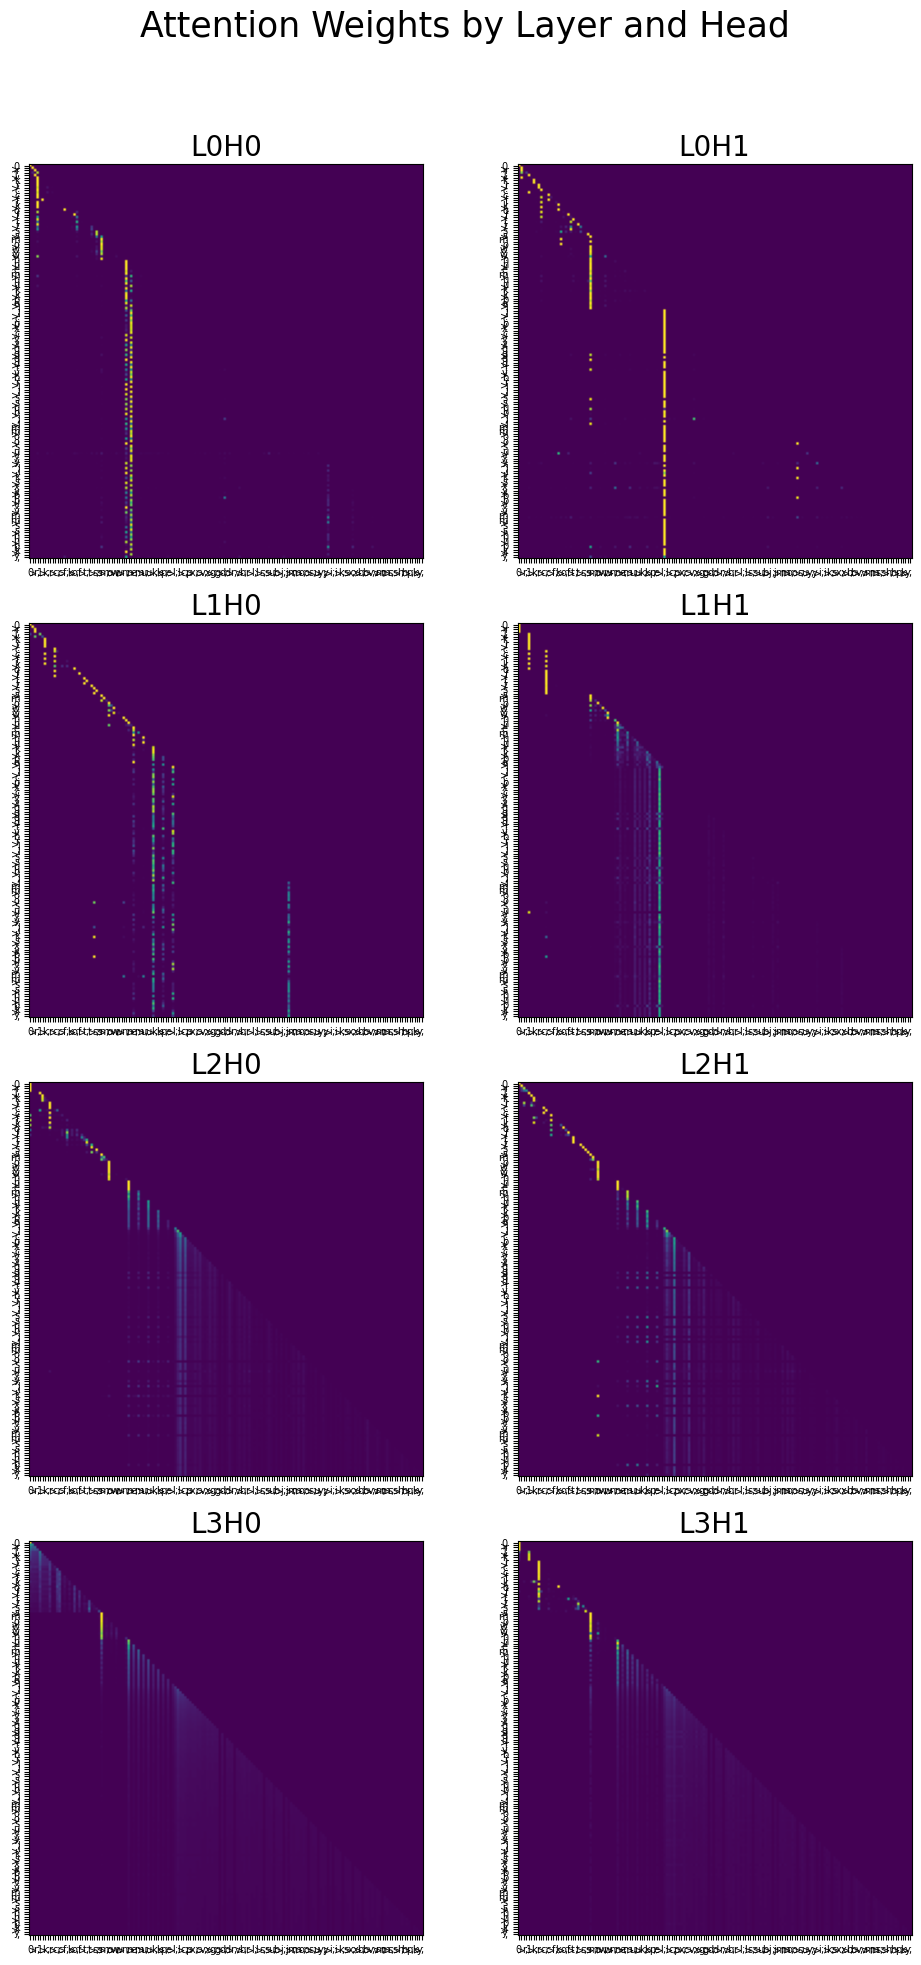

In [33]:
# plot attention weights over layers and heads

token_labels = list(prompt)
num_layers = len(attn_weights)
num_heads = config.num_heads
total_heads = num_layers * num_heads

rows = num_layers
cols = num_heads
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), squeeze=False)

head_idx = 0
for layer_idx, attn_weight_heads in enumerate(attn_weights):
    for head_number in range(num_heads):
        row = head_idx // cols
        col = head_idx % cols
        ax = axes[row][col]

        attn_weight = attn_weight_heads[0, head_number].detach().cpu().numpy()
        im = ax.imshow(attn_weight, cmap="viridis")

        ax.set_title(f"L{layer_idx}H{head_number}", fontsize=20)

        ax.set_xticks(range(len(token_labels)))
        ax.set_xticklabels(token_labels, fontsize=7)
        ax.set_yticks(range(len(token_labels)))
        ax.set_yticklabels(token_labels, fontsize=7)

        head_idx += 1

# Hide any unused subplots
for i in range(head_idx, rows * cols):
    fig.delaxes(axes[i // cols][i % cols])

fig.suptitle("Attention Weights by Layer and Head", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [34]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

size = 1000
font_size = 10

token_labels = list(prompt)
num_layers = len(attn_weights)
num_heads = config.num_heads
seq_len = len(token_labels)
tick_vals = list(range(seq_len))

fig = make_subplots(
    rows=num_layers, cols=num_heads,
    subplot_titles=[f"L{l}H{h}" for l in range(num_layers) for h in range(num_heads)],
    horizontal_spacing=0.03, vertical_spacing=0.06
)

for layer_idx in range(num_layers):
    for head_number in range(num_heads):
        attn = attn_weights[layer_idx][0, head_number].detach().cpu().numpy()

        fig.add_trace(
            go.Heatmap(
                z=attn,
                x=tick_vals,
                y=tick_vals,
                colorscale='Viridis',
                colorbar=dict(len=0.4),
                zmin=0,
                zmax=1,
            ),
            row=layer_idx + 1,
            col=head_number + 1
        )

# Apply axis formatting
for row in range(1, num_layers + 1):
    for col in range(1, num_heads + 1):
        fig.update_xaxes(
            tickmode='array',
            tickvals=tick_vals,
            ticktext=token_labels,
            type='linear',
            tickfont=dict(size=font_size),
            row=row, col=col
        )
        fig.update_yaxes(
            tickmode='array',
            tickvals=tick_vals,
            ticktext=token_labels,
            type='linear',
            tickfont=dict(size=font_size),
            autorange='reversed',  # flip y-axis
            row=row, col=col
        )

fig.update_layout(
    height=num_layers * 1000,
    width=num_heads * 1000,
    title_text="Attention Weights by Layer and Head",
    title_x=0.5,
    showlegend=False
)

fig.show()
